## **Data Cleaning and EDA for Jobs in Malaysia**

### Install package

In [2]:
%pip install seaborn matplotlib
%pip install sentence_transformers
%pip install torch
%pip install hdbscan

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Data Cleaning

In [3]:
import pandas as pd

#Load dataset
df = pd.read_csv('C:\\Users\\HP\\OneDrive\\Documents\\VSC codes\\WIH3001 Project\\jobs_myfuturejobs.csv')

#Data Cleaning

#Show basic info
print("Initial shape:", df.shape)
print(df.info())
print(df.isnull().sum())

Initial shape: (12662, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12662 entries, 0 to 12661
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        12662 non-null  object 
 1   title         12662 non-null  object 
 2   company       12662 non-null  object 
 3   location      12662 non-null  object 
 4   salary        12662 non-null  int64  
 5   date_posted   0 non-null      float64
 6   contractType  12662 non-null  object 
 7   source        12662 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 791.5+ KB
None
job_id              0
title               0
company             0
location            0
salary              0
date_posted     12662
contractType        0
source              0
dtype: int64


In [4]:
df.head()

,job_id,title,company,location,salary,date_posted,contractType,source
0,b6a7eadc30d542b2af6e87a730045cb8,CONSULTANT NAARABELLE FACESPA- ALOR SETAR,NAARA FACESPA SDN BHD,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2500,NaN,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs
1,96ff1bf3106444a4886e76c203ef954c,GENERAL WORKER,Singhap (Kedah) Sdn Bhd,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",1700,NaN,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs
2,7bc5175af9324b1fbede14967050da0c,Supervision,MERIDIAN WORLD SDN BHD,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",2000,NaN,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs
3,604dab81729144d1b3ba3f4ec4b0d51d,Assistant Cafe Manager - Aurelius Hospital Alo...,O'Briens Irish Sandwich Bars (Shinning Continu...,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2800,NaN,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs
4,ee6f56c1e3db49e0912a27bd7db4c13b,"ACCOUNT, AUDIT AND TAX",SS Management Services,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_jitra', 'P...",1700,NaN,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs


In [5]:
#Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())
print("\nDuplicate rows:")
print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)))

Number of duplicate rows: 0

Duplicate rows:
Empty DataFrame
Columns: [job_id, title, company, location, salary, date_posted, contractType, source]
Index: []


In [6]:
#Drop date_posted column since there is no data
df = df.drop(columns=['date_posted'])
print(df.columns)

Index(['job_id', 'title', 'company', 'location', 'salary', 'contractType',
       'source'],
      dtype='object')


In [7]:
import re

#Mapping of state codes to state names in Malaysia
state_code_map = {
    'MY_KDH': 'Kedah',
    'MY_PRK': 'Perak',
    'MY_PLS': 'Perlis',
    'MY_PNG': 'Pulau Pinang',
    'MY_KTN': 'Kelantan',
    'MY_TGG': 'Terengganu',
    'MY_PHG': 'Pahang',
    'MY_JHR': 'Johor',
    'MY_SGR': 'Selangor',
    'MY_KUL': 'W.P. Kuala Lumpur',
    'MY_LBN': 'W.P. Labuan',
    'MY_PJY': 'W.P. Putrajaya',
    'MY_MLK': 'Melaka',
    'MY_NSN': 'Negeri Sembilan',
    'MY_SBH': 'Sabah',
    'MY_SRW': 'Sarawak'
}

def extract_state_district(location_str):
    #Extract state code
    state_match = re.search(r"'STATE':\s*'([^']+)'", location_str)
    state_code = state_match.group(1) if state_match else None
    state = state_code_map.get(state_code, None)
    
    #Extract city/district
    city_match = re.search(r"'CITY':\s*'([^']+)'", location_str)
    district = None
    if city_match:
        city_code = city_match.group(1)
        #Format: MY_KDH_sungai_petani
        parts = city_code.split('_')
        if len(parts) >= 3:
            #Join all after state code as district name
            district = '_'.join(parts[2:]).replace('_', ' ').title()
    return pd.Series({'state': state, 'district': district})

#Apply extraction to each row
df[['state', 'district']] = df['location'].apply(extract_state_district)
print(df[['location', 'state', 'district']].head())

                                            location  state       district
0  {'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...  Kedah     Alor Setar
1  {'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...  Kedah     Alor Setar
2  {'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...  Kedah  Sungai Petani
3  {'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...  Kedah     Alor Setar
4  {'STATE': 'MY_KDH', 'CITY': 'MY_KDH_jitra', 'P...  Kedah          Jitra


In [8]:
import ast

#Parser using ast.literal_eval for safety
def parse_contract(s):
    if pd.isna(s):
        return pd.Series({'contract_type_name': None, 'contract_type_id': None})
    try:
        d = ast.literal_eval(s)
        #Some rows could already be dicts or malformed strings
        if isinstance(d, dict):
            return pd.Series({'contract_type_name': d.get('name'), 'contract_type_id': d.get('id')})
    except Exception:
        #Fallback: try simple regex
        import re
        name_match = re.search(r"'name':\\s*'([^']+)'", str(s))
        id_match = re.search(r"'id':\\s*'([^']+)'", str(s))
        return pd.Series({'contract_type_name': name_match.group(1) if name_match else None,
                          'contract_type_id': id_match.group(1) if id_match else None})
    return pd.Series({'contract_type_name': None, 'contract_type_id': None})

df[['contract_type_name', 'contract_type_id']] = df['contractType'].apply(parse_contract)
#Normalize names a little
df['contract_type_name'] = df['contract_type_name'].str.strip().str.title().fillna('Unknown')
df['contract_type_name'] = df['contract_type_name'].astype('category')

In [9]:
df.head()

,job_id,title,company,location,salary,contractType,source,state,district,contract_type_name,contract_type_id
0,b6a7eadc30d542b2af6e87a730045cb8,CONSULTANT NAARABELLE FACESPA- ALOR SETAR,NAARA FACESPA SDN BHD,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2500,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1
1,96ff1bf3106444a4886e76c203ef954c,GENERAL WORKER,Singhap (Kedah) Sdn Bhd,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1
2,7bc5175af9324b1fbede14967050da0c,Supervision,MERIDIAN WORLD SDN BHD,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",2000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Sungai Petani,Permanent,1
3,604dab81729144d1b3ba3f4ec4b0d51d,Assistant Cafe Manager - Aurelius Hospital Alo...,O'Briens Irish Sandwich Bars (Shinning Continu...,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2800,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1
4,ee6f56c1e3db49e0912a27bd7db4c13b,"ACCOUNT, AUDIT AND TAX",SS Management Services,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_jitra', 'P...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Jitra,Permanent,1


### Exploratory Data Analysis (EDA)

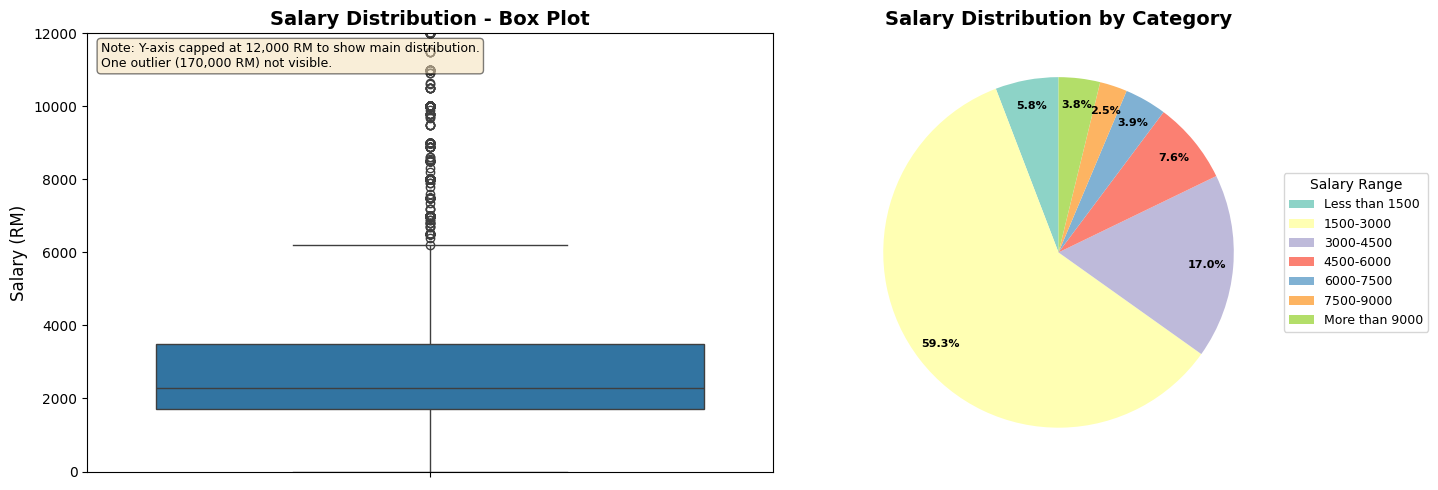

Salary Statistics:
count    1.266200e+04
mean     4.354174e+03
std      1.333827e+05
min      0.000000e+00
25%      1.700000e+03
50%      2.300000e+03
75%      3.500000e+03
max      1.500200e+07
Name: salary, dtype: float64

Salary Category Distribution:
salary_category
Less than 1500     737
1500-3000         7513
3000-4500         2155
4500-6000          962
6000-7500          491
7500-9000          320
More than 9000     484
Name: count, dtype: int64

Note: There is 1 outlier with salary = 170,000 RM


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#Create salary categories
def categorize_salary(salary):
	if salary < 1500:
		return 'Less than 1500'
	elif salary < 3000:
		return '1500-3000'
	elif salary < 4500:
		return '3000-4500'
	elif salary < 6000:
		return '4500-6000'
	elif salary < 7500:
		return '6000-7500'
	elif salary < 9000:
		return '7500-9000'
	else:
		return 'More than 9000'

df['salary_category'] = df['salary'].apply(categorize_salary)

#Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Box plot: cap y-axis to show main distribution (0 to 12000)
#This prevents the single outlier (170000) from compressing the view
sns.boxplot(y='salary', data=df, ax=axes[0])
axes[0].set_title('Salary Distribution - Box Plot', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Salary (RM)', fontsize=12)
axes[0].set_ylim(0, 12000)  # Focus on main data range
axes[0].text(0.02, 0.98, 'Note: Y-axis capped at 12,000 RM to show main distribution.\nOne outlier (170,000 RM) not visible.', 
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#Pie chart
salary_counts = df['salary_category'].value_counts()
salary_order = ['Less than 1500', '1500-3000', '3000-4500', '4500-6000', '6000-7500', '7500-9000', 'More than 9000']
salary_counts = salary_counts.reindex(salary_order)

colors = plt.cm.Set3(range(len(salary_counts)))
wedges, texts, autotexts = axes[1].pie(salary_counts, labels=None, autopct='%1.1f%%', 
                                         startangle=90, colors=colors, pctdistance=0.85)

#Improve percentage text positioning to prevent overlap
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)

axes[1].set_title('Salary Distribution by Category', fontsize=14, fontweight='bold')

#Add legend outside the pie chart
axes[1].legend(wedges, salary_counts.index, title='Salary Range', loc='center left', 
               bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

plt.tight_layout()
plt.show()

#Print summary statistics
print("Salary Statistics:")
print(df['salary'].describe())
print("\nSalary Category Distribution:")
print(salary_counts)
print("\nNote: There is 1 outlier with salary = 170,000 RM")

In [11]:
#Top 10 highest-salary jobs in the "More than 9000" category
top_high_salary = (
    df[df['salary_category'] == 'More than 9000']
    .sort_values('salary', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_high_salary[['title', 'company', 'state', 'district', 'salary']]

,title,company,state,district,salary
0,Retail Assistant (RM10/Hour) KLIA MITSUI,Agensi Pekerjaan Recruit Express Sdn Bhd,Selangor,Klia,15001999
1,ACCOUNT EXECUTIVE,XERA SDN BHD,W.P. Kuala Lumpur,Kuala Lumpur,300000
2,Admin Assistant,AZ PERMAS TYRE & RIM SDN BHD,Johor,Johor Bahru,190000
3,Senior SCM Manager-Gelang Patah (15-20K) (REF TN),Agensi Pekerjaan My Recruit Direct Sdn Bhd,Johor,Gelang Patah,180000
4,PEKERJA AM,EURASIA EXPRESS SDN BHD,Kedah,Sungai Petani,170000
5,GENERAL WORKER,KRISTAL VEGA SDN BHD,Sabah,Kota Kinabalu,170000
6,Japanese Market Renewal Sales Specialist,Infoblox Malaysia Sdn. Bhd.,W.P. Kuala Lumpur,Kuala Lumpur,122500
7,FACTORY MANAGER,Nala Employment Services,Johor,Johor Bahru,64500
8,FACTORY MANAGER,Nala Employment Services,Johor,Johor Bahru,64500
9,Foreman,NABALU O&G SUPPLY AND SERVICES SDN. BHD.,Sabah,Kota Kinabalu,30960


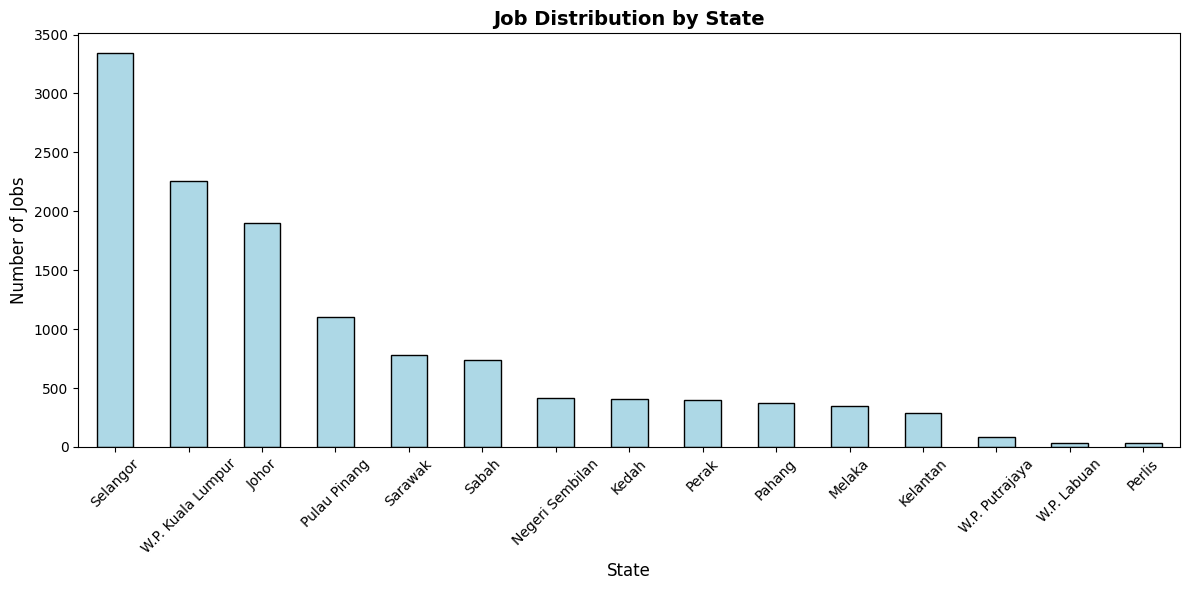

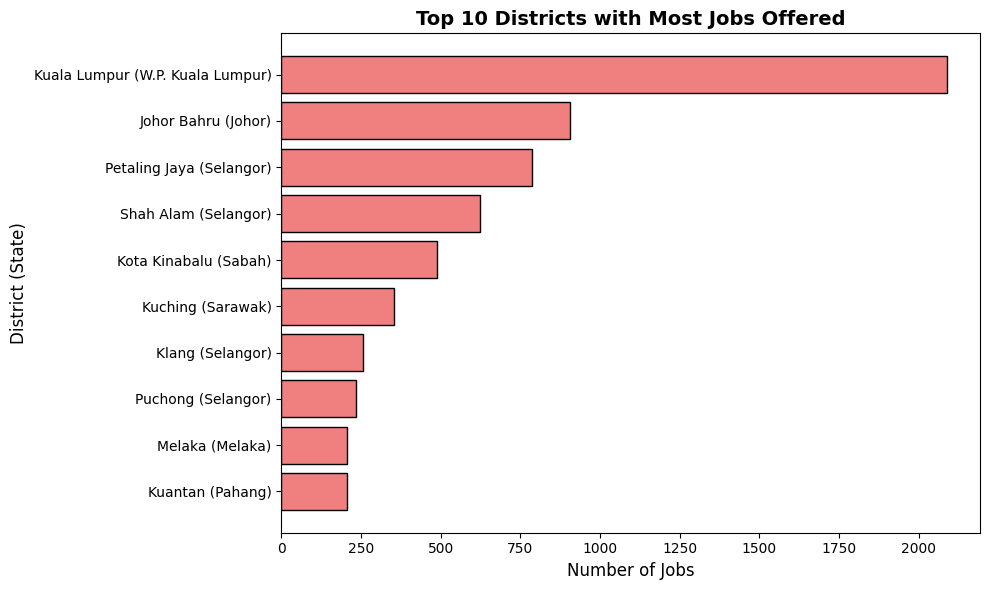

In [12]:
#Bar chart: Job Distribution by State
fig1, ax1 = plt.subplots(figsize=(12, 6))
state_counts = df['state'].value_counts().sort_values(ascending=False)
state_counts.plot(kind='bar', ax=ax1, color='lightblue', edgecolor='black')
ax1.set_title('Job Distribution by State', fontsize=14, fontweight='bold')
ax1.set_xlabel('State', fontsize=12)
ax1.set_ylabel('Number of Jobs', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#Horizontal bar chart: Top 10 Districts with Most Jobs
fig2, ax2 = plt.subplots(figsize=(10, 6))
top_10_districts = df.groupby(['district', 'state']).size().sort_values(ascending=True).tail(10)
top_10_districts_labels = [f"{district} ({state})" for district, state in top_10_districts.index]
ax2.barh(top_10_districts_labels, top_10_districts.values, color='lightcoral', edgecolor='black')
ax2.set_title('Top 10 Districts with Most Jobs Offered', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Jobs', fontsize=12)
ax2.set_ylabel('District (State)', fontsize=12)
plt.tight_layout()
plt.show()

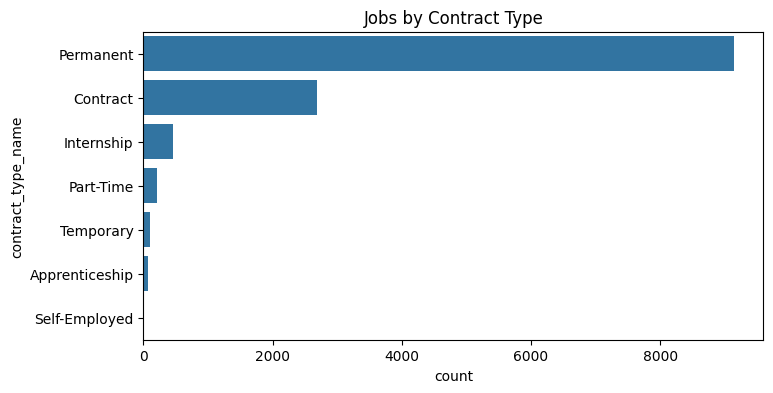


Contract Type Distribution:
contract_type_name
Permanent         9141
Contract          2684
Internship         461
Part-Time          204
Temporary           95
Apprenticeship      66
Self-Employed       11
Name: count, dtype: int64


In [13]:
#Horizontal bar chart: Jobs by Contract Type
plt.figure(figsize=(8,4))
sns.countplot(data=df, y='contract_type_name', order=df['contract_type_name'].value_counts().index)
plt.title('Jobs by Contract Type')
plt.show()

contractType_counts = df['contract_type_name'].value_counts()
print("\nContract Type Distribution:")
print(contractType_counts)

In [14]:
df.head()

,job_id,title,company,location,salary,contractType,source,state,district,contract_type_name,contract_type_id,salary_category
0,b6a7eadc30d542b2af6e87a730045cb8,CONSULTANT NAARABELLE FACESPA- ALOR SETAR,NAARA FACESPA SDN BHD,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2500,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1,1500-3000
1,96ff1bf3106444a4886e76c203ef954c,GENERAL WORKER,Singhap (Kedah) Sdn Bhd,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1,1500-3000
2,7bc5175af9324b1fbede14967050da0c,Supervision,MERIDIAN WORLD SDN BHD,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",2000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Sungai Petani,Permanent,1,1500-3000
3,604dab81729144d1b3ba3f4ec4b0d51d,Assistant Cafe Manager - Aurelius Hospital Alo...,O'Briens Irish Sandwich Bars (Shinning Continu...,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2800,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1,1500-3000
4,ee6f56c1e3db49e0912a27bd7db4c13b,"ACCOUNT, AUDIT AND TAX",SS Management Services,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_jitra', 'P...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Jitra,Permanent,1,1500-3000


### Modelling

In [ ]:
#Remove salary outliers > 500,000 and reset index so subsequent cells use the cleaned df
outlier_mask = df['salary'] > 500000
n_outliers = outlier_mask.sum()
if n_outliers:
    df = df[~outlier_mask].reset_index(drop=True)
print(f"Removed {n_outliers} rows with salary > 500000. New shape: {df.shape}")

Removed 1 rows with salary > 500000. New shape: (12661, 12)


In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

Embed job titles, and cluster them into similar job categories

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

embedder = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

train_title_embeddings = embedder.encode(
    train_df['title'].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

test_title_embeddings = embedder.encode(
    test_df['title'].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

c:\Users\HP\OneDrive\Documents\VSC codes\WIH3001 Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 119/119 [00:47<00:00,  2.48it/s]


In [18]:
import hdbscan
from hdbscan import approximate_predict

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=5,          
    metric='euclidean',     
    prediction_data=True    
)

train_clusters = clusterer.fit_predict(train_title_embeddings)
test_clusters, strengths = approximate_predict(clusterer, test_title_embeddings)
print("test_clusters type/shape:", type(test_clusters), getattr(test_clusters, 'shape', None))
print("sample test cluster labels:", test_clusters[:10])

test_clusters type/shape: <class 'numpy.ndarray'> (3799,)
sample test cluster labels: [ -1  -1  -1  -1 135  -1  -1  -1  -1  45]


In [19]:
unique, counts = np.unique(train_clusters, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
cluster_sizes

{np.int64(-1): np.int64(5857),
 np.int64(0): np.int64(12),
 np.int64(1): np.int64(11),
 np.int64(2): np.int64(10),
 np.int64(3): np.int64(14),
 np.int64(4): np.int64(21),
 np.int64(5): np.int64(13),
 np.int64(6): np.int64(32),
 np.int64(7): np.int64(14),
 np.int64(8): np.int64(21),
 np.int64(9): np.int64(20),
 np.int64(10): np.int64(18),
 np.int64(11): np.int64(10),
 np.int64(12): np.int64(18),
 np.int64(13): np.int64(11),
 np.int64(14): np.int64(14),
 np.int64(15): np.int64(12),
 np.int64(16): np.int64(54),
 np.int64(17): np.int64(16),
 np.int64(18): np.int64(10),
 np.int64(19): np.int64(12),
 np.int64(20): np.int64(16),
 np.int64(21): np.int64(11),
 np.int64(22): np.int64(15),
 np.int64(23): np.int64(10),
 np.int64(24): np.int64(38),
 np.int64(25): np.int64(24),
 np.int64(26): np.int64(21),
 np.int64(27): np.int64(30),
 np.int64(28): np.int64(16),
 np.int64(29): np.int64(15),
 np.int64(30): np.int64(106),
 np.int64(31): np.int64(11),
 np.int64(32): np.int64(50),
 np.int64(33): np.int

In [20]:
train_df["title_cluster"] = train_clusters.astype(str)
test_df["title_cluster"] = test_clusters.astype(str)

print("Train cluster distribution:")
print(train_df["title_cluster"].value_counts().head(10))

print("\nTest cluster distribution:")
print(test_df["title_cluster"].value_counts().head(10))

Train cluster distribution:
title_cluster
-1     5857
151     117
30      106
93       61
16       54
91       50
32       50
135      49
71       47
137      46
Name: count, dtype: int64

Test cluster distribution:
title_cluster
-1     2656
151      52
93       35
30       33
135      25
108      21
91       19
16       17
137      15
32       15
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import silhouette_score

#Mask out noise points
mask = train_clusters != -1

filtered_embeddings = train_title_embeddings[mask]
filtered_labels = train_clusters[mask]

#Ensure enough clusters exist
n_clusters = len(set(filtered_labels))
print("Number of clusters (excluding noise):", n_clusters)

if n_clusters > 1:
    silhouette = silhouette_score(
        filtered_embeddings,
        filtered_labels,
        metric='cosine'
    )
    print("Silhouette score:", silhouette)
else:
    print("Not enough clusters for silhouette evaluation")

Number of clusters (excluding noise): 153
Silhouette score: 0.6249374151229858


Scaling and define the score before training the model

In [22]:
#Assign cluster labels back to the main dataframe
df['title_cluster'] = None
df.loc[train_df.index, 'title_cluster'] = train_clusters.astype(str)
df.loc[test_df.index,  'title_cluster'] = test_clusters.astype(str)

#Recreate df_score after title_cluster is available so grouping uses the updated labels
from sklearn.preprocessing import MinMaxScaler
df_score = df.copy()
scaler = MinMaxScaler()
df_score['salary_norm'] = scaler.fit_transform(df_score[['salary']])

#Compute cluster-level mean normalized salary and map back to rows
cluster_salary_score = df_score.groupby('title_cluster')['salary_norm'].mean()
df_score['title_cluster_score'] = df_score['title_cluster'].map(cluster_salary_score)

In [23]:
contract_weight = {
    "Permanent": 1.0,
    "Contract": 0.75,
    "Part-time": 0.5,
    "Internship": 0.4,
    "Temporary": 0.2,
    "Apprenticeship": 0.15,
    "Self-employed": 0.1
}

df_score['contract_score'] = df_score['contract_type_name'].map(contract_weight).fillna(0.6)

In [24]:
df_score['job_score'] = (
    25 * df_score['salary_norm'] +
    10 * df_score['title_cluster_score'] +
    0.20 * df_score['contract_score']
)

In [25]:
df_score.head()

,job_id,title,company,location,salary,contractType,source,state,district,contract_type_name,contract_type_id,salary_category,title_cluster,salary_norm,title_cluster_score,contract_score,job_score
0,b6a7eadc30d542b2af6e87a730045cb8,CONSULTANT NAARABELLE FACESPA- ALOR SETAR,NAARA FACESPA SDN BHD,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2500,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1,1500-3000,-1,0.008333,0.011036,1.0,0.518694
1,96ff1bf3106444a4886e76c203ef954c,GENERAL WORKER,Singhap (Kedah) Sdn Bhd,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1,1500-3000,52,0.005667,0.027192,1.0,0.613590
2,7bc5175af9324b1fbede14967050da0c,Supervision,MERIDIAN WORLD SDN BHD,"{'COUNTRY': 'MY', 'STATE': 'MY_KDH', 'CITY': '...",2000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Sungai Petani,Permanent,1,1500-3000,-1,0.006667,0.011036,1.0,0.477028
3,604dab81729144d1b3ba3f4ec4b0d51d,Assistant Cafe Manager - Aurelius Hospital Alo...,O'Briens Irish Sandwich Bars (Shinning Continu...,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_alor_setar...",2800,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Alor Setar,Permanent,1,1500-3000,-1,0.009333,0.011036,1.0,0.543694
4,ee6f56c1e3db49e0912a27bd7db4c13b,"ACCOUNT, AUDIT AND TAX",SS Management Services,"{'STATE': 'MY_KDH', 'CITY': 'MY_KDH_jitra', 'P...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Kedah,Jitra,Permanent,1,1500-3000,-1,0.005667,0.011036,1.0,0.452028


In [26]:
features = ["state", "district", "contract_type_name", "title_cluster", "salary"]

X_train = train_df[features]
X_test  = test_df[features]

train_df['job_score'] = df_score.loc[train_df.index, 'job_score']
test_df['job_score']  = df_score.loc[test_df.index,  'job_score']

y_train = train_df['job_score']
y_test  = test_df['job_score']

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ["state", "district", "contract_type_name", "title_cluster"]
numeric_cols = ["salary"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", "passthrough", numeric_cols)
])

Linear Regression

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

lr_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


CatBoost

In [30]:
features = ["state","district","contract_type_name","title_cluster","salary"]
X_train = train_df[features].copy()
X_test  = test_df[features].copy()

category_features = ['state','district','contract_type_name','title_cluster']
for c in category_features:
    X_train[c] = X_train[c].astype(object).fillna('Unknown').astype('category')
    X_test[c]  = X_test[c].astype(object).fillna('Unknown').astype('category')
    X_test[c]  = X_test[c].cat.set_categories(X_train[c].cat.categories)

In [31]:
cat_idx = [X_train.columns.get_loc(c) for c in category_features]

In [ ]:
from catboost import Pool

#Ensure these are the categorical features you're passing to Pool
category_features = ['state','district','contract_type_name','title_cluster']

#Convert to string and fill NaNs (do this on the exact X_train/X_test you pass to Pool)
for c in category_features:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

#Recompute categorical indices from X_train
cat_idx = [X_train.columns.get_loc(c) for c in category_features if c in X_train.columns]
print("cat_idx:", cat_idx)
print("Missing in train cats:", X_train[category_features].isnull().sum().to_dict())
print("Missing in test cats :", X_test[category_features].isnull().sum().to_dict())

#Create Pools (should no longer raise the NaN error)
train_pool = Pool(X_train, label=y_train, cat_features=cat_idx)
test_pool  = Pool(X_test,  label=y_test,  cat_features=cat_idx)

cat_idx: [0, 1, 2, 3]
Missing in train cats: {'state': 0, 'district': 0, 'contract_type_name': 0, 'title_cluster': 0}
Missing in test cats : {'state': 0, 'district': 0, 'contract_type_name': 0, 'title_cluster': 0}


In [33]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(iterations=50, verbose=20)
cat_model.fit(train_pool, eval_set=test_pool)

Learning rate set to 0.44595
0:	learn: 0.2848904	test: 0.3711712	best: 0.3711712 (0)	total: 174ms	remaining: 8.5s
20:	learn: 0.0267336	test: 0.1691381	best: 0.1691381 (20)	total: 883ms	remaining: 1.22s
40:	learn: 0.0200707	test: 0.1660356	best: 0.1660348 (38)	total: 1.72s	remaining: 377ms
49:	learn: 0.0187660	test: 0.1656681	best: 0.1656681 (49)	total: 2.1s	remaining: 0us

bestTest = 0.1656681229
bestIteration = 49



### Evaluation

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R²  :", r2_score(y_test, y_pred))

In [35]:
evaluate(lr_model, X_test, y_test, "Linear Regression")
evaluate(rf_model, X_test, y_test, "Random Forest")
evaluate(cat_model, X_test, y_test, "CatBoost")


Linear Regression
MAE : 0.004230996464783383
RMSE: 0.006879035446068634
R²  : 0.9997767827034522

Random Forest
MAE : 0.006678551763330774
RMSE: 0.19826219632999031
R²  : 0.8145817083902106

CatBoost
MAE : 0.010738229859520205
RMSE: 0.1656681234731184
R²  : 0.8705355128087685


In [36]:
#To check whether there is any overfitting
evaluate(lr_model, X_train, y_train, "Linear Regression")


Linear Regression
MAE : 0.004420891375222875
RMSE: 0.0071309734735597015
R²  : 0.9996810422051602


Model used: Linear Regression

In [37]:
train_df.head()

,job_id,title,company,location,salary,contractType,source,state,district,contract_type_name,contract_type_id,salary_category,title_cluster,job_score
4414,18fb406a2aa54480b7e6cab24bae50aa,Housekeeping Supervisor,HOLIDAY INN & SUITES PENANG PRAI,"{'COUNTRY': 'MY', 'STATE': 'MY_PNG', 'CITY': '...",2000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Pulau Pinang,Bukit Mertajam,Permanent,1,1500-3000,32,0.430933
1020,25ace16997794123b22a4aca31785e69,Facility Management and Control System Engineer,Envipure Sdn Bhd,"{'STATE': 'MY_MLK', 'CITY': 'MY_MLK_melaka', '...",3500,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Melaka,Melaka,Permanent,1,3000-4500,-1,0.602028
705,597b3be5dbac484f925c5b3212449c91,Licensed Mobile Crane 25 Ton,LLC INFRA SDN BHD,"{'STATE': 'MY_KTN', 'CITY': 'MY_KTN_gua_musang...",3200,"{'id': '4', 'name': 'Contract'}",MyFutureJobs,Kelantan,Gua Musang,Contract,4,3000-4500,-1,0.527028
9419,f20c5bd9fb5a43659598605c4a895924,pekerja am kilang,BT CHEMICALS SDN BHD,"{'COUNTRY': 'MY', 'STATE': 'MY_SGR', 'CITY': '...",1700,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Selangor,Bandar Baru Bangi,Permanent,1,1500-3000,136,0.398333
1866,3795c4b631a647b4ba2951e2acd9ba0e,SITE SAFETY SUPERVISOR,Usaha Pammek Sdn Bhd,"{'COUNTRY': 'MY', 'STATE': 'MY_PRK', 'CITY': '...",3500,"{'id': '4', 'name': 'Contract'}",MyFutureJobs,Perak,Ipoh,Contract,4,3000-4500,57,0.565303


In [38]:
test_df.head()

,job_id,title,company,location,salary,contractType,source,state,district,contract_type_name,contract_type_id,salary_category,title_cluster,job_score
6373,f38a34bcfb2944bba7188148162e9fef,FULLTIME LAZADA HUB PASIR GUDANG,Synergy Staffing Sdn Bhd,"{'STATE': 'MY_JHR', 'CITY': 'MY_JHR_masai', 'P...",1800,"{'id': '4', 'name': 'Contract'}",MyFutureJobs,Johor,Masai,Contract,4,1500-3000,-1,0.410361
8940,94ebaeb15e094faf8484ccea703ef712,Technical Solutions Specialist,Kloudynet Technologies Sdn. Bhd.,"{'COUNTRY': 'MY', 'STATE': 'MY_KUL', 'CITY': '...",20000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,W.P. Kuala Lumpur,Kuala Lumpur,Permanent,1,More than 9000,-1,1.977028
10989,4caa3e01260e4bfa99e13d3bc00109ab,Clinic Manager,SOMERSET HEALTHCARE SDN BHD,"{'COUNTRY': 'MY', 'STATE': 'MY_SGR', 'CITY': '...",3000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Selangor,Telok Panglima Garang,Permanent,1,3000-4500,-1,0.560361
5329,21a36928edfe4ce19c53d97c7566ebd0,"Executive, Internal Audit",JOHOR PORT BERHAD,"{'COUNTRY': 'MY', 'STATE': 'MY_JHR', 'CITY': '...",3200,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,Johor,Pasir Gudang,Permanent,1,3000-4500,-1,0.577028
8899,93ab6d7641c844dabd96ae58141d0ddd,Sales Executive,Vivopac Marketing Sdn Bhd,"{'COUNTRY': 'MY', 'STATE': 'MY_KUL', 'CITY': '...",4000,"{'id': '1', 'name': 'Permanent'}",MyFutureJobs,W.P. Kuala Lumpur,Cheras,Permanent,1,3000-4500,135,0.626698


In [44]:
#Predict with trained linear regression and save results
#Build feature matrix X from df_score (same features used for training)
features = ["state", "district", "contract_type_name", "title_cluster", "salary"]
X = df_score[features].copy()
#Ensure categorical columns have no NaNs (OneHotEncoder was set to handle_unknown="ignore")
for c in ["state", "district", "contract_type_name", "title_cluster"]:
    X[c] = X[c].astype(object).fillna('Unknown')

df_output = df_score.copy()
df_output['lr_pred_score'] = lr_model.predict(X)
df_output['lr_residual'] = df_output['job_score'] - df_output['lr_pred_score']

df_output.to_csv('job_scores.csv', index=False)

print("Saved: job_scores.csv")

Saved: job_scores.csv
